In [96]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset Class
class Fer2013Dataset(Dataset):
    def __init__(self, csv_file, phase, transform=None):
        self.data = pd.read_csv(csv_file)
        self.phase = phase  # 'Training', 'PublicTest', or 'PrivateTest'
        self.transform = transform
        self.data = self.data[self.data['Usage'] == phase]
        self.images = self.data['pixels'].tolist()
        self.labels = self.data['emotion'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = np.fromstring(self.images[idx], dtype=int, sep=' ')
        image = image.reshape(48, 48).astype('uint8')
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = Fer2013Dataset(
    csv_file='/home/da23c014/PrivacyAI/CourseProject/datasets/fer2013/fer2013.csv',
    phase='Training',
    transform=train_transform
)

val_dataset = Fer2013Dataset(
    csv_file='/home/da23c014/PrivacyAI/CourseProject/datasets/fer2013/fer2013.csv',
    phase='PublicTest',
    transform=val_transform
)


In [97]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Number of emotion classes in Fer2013
num_classes = 7  # Adjust if necessary

# Load pre-trained ResNet-18 model with new 'weights' parameter
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the first convolutional layer to accept single-channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [98]:
# Define batch size
batch_size = 64  # Adjust based on your GPU memory

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


In [99]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [100]:
len(train_dataset)

28709

In [101]:
num_epochs = 6  # Adjust based on your requirements

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_preds.double() / len(train_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Step the scheduler if using one
    scheduler.step()


Epoch 1/6, Loss: 1.7754, Accuracy: 0.3160
Epoch 2/6, Loss: 1.4634, Accuracy: 0.4353
Epoch 3/6, Loss: 1.4069, Accuracy: 0.4597
Epoch 4/6, Loss: 1.2711, Accuracy: 0.5172
Epoch 5/6, Loss: 1.1792, Accuracy: 0.5549
Epoch 6/6, Loss: 1.0196, Accuracy: 0.6186


In [102]:
model.eval()
val_running_loss = 0.0
val_correct_preds = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct_preds += torch.sum(preds == labels.data)

val_loss = val_running_loss / len(val_dataset)
val_acc = val_correct_preds.double() / len(val_dataset)

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


Validation Loss: 1.1496, Validation Accuracy: 0.5698


In [39]:
len(train_loader)


449

## DP-SGD

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset Class
class Fer2013Dataset(Dataset):
    def __init__(self, csv_file, phase, transform=None):
        self.data = pd.read_csv(csv_file)
        self.phase = phase  # 'Training', 'PublicTest', or 'PrivateTest'
        self.transform = transform
        self.data = self.data[self.data['Usage'] == phase]
        self.images = self.data['pixels'].tolist()
        self.labels = self.data['emotion'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = np.fromstring(self.images[idx], dtype=int, sep=' ')
        image = image.reshape(48, 48).astype('uint8')
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = Fer2013Dataset(
    csv_file='/home/da23c014/PrivacyAI/CourseProject/datasets/fer2013/fer2013.csv',
    phase='Training',
    transform=train_transform
)

val_dataset = Fer2013Dataset(
    csv_file='/home/da23c014/PrivacyAI/CourseProject/datasets/fer2013/fer2013.csv',
    phase='PublicTest',
    transform=val_transform
)


In [2]:
import torch.nn as nn

def replace_batchnorm_with_groupnorm(model, num_groups=32):
    """
    Recursively replace all BatchNorm2d layers with GroupNorm in a model.

    Args:
        model (nn.Module): The model in which to replace BatchNorm layers.
        num_groups (int): The number of groups to use in GroupNorm.
    """
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            num_channels = module.num_features
            # Ensure num_groups divides num_channels
            num_groups = min(num_groups, num_channels)
            if num_channels % num_groups != 0:
                # Adjust num_groups if it doesn't divide num_channels
                for ng in reversed(range(1, num_groups)):
                    if num_channels % ng == 0:
                        num_groups = ng
                        break
            gn = nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)
            setattr(model, name, gn)
        else:
            replace_batchnorm_with_groupnorm(module, num_groups=num_groups)


In [3]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
# Number of emotion classes in Fer2013
num_classes = 7  # Adjust if necessary

# Load pre-trained ResNet-18 model with new 'weights' parameter
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)


# Modify the first convolutional layer to accept single-channel images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Replace BatchNorm layers with GroupNorm
replace_batchnorm_with_groupnorm(model, num_groups=32)



In [4]:
from torch.func import functional_call

# Get model parameters and buffers
params = {k: v.detach() for k, v in model.named_parameters()}
buffers = {k: v.detach() for k, v in model.named_buffers()}


In [5]:
from dp_accounting import dp_event as event
from dp_accounting.rdp import rdp_privacy_accountant as rdp
import numpy as np
from scipy import optimize as opt

# Function to compute the noise multiplier using RDPAccountant
def get_noise_multiplier(epsilon, delta, sampling_rate, steps):
    RDP_ORDERS = (
        [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5]
        + list(range(5, 64))
        + [128, 256, 512]
    )

    def objective(noise_multiplier):
        accountant = rdp.RdpAccountant(orders=RDP_ORDERS)
        dp_event = event.SelfComposedDpEvent(
            event.PoissonSampledDpEvent(
                sampling_rate, event.GaussianDpEvent(noise_multiplier)
            ),
            steps,
        )
        accountant.compose(dp_event)
        return accountant.get_epsilon(delta) - epsilon

    # Handle cases where the function does not cross zero
    try:
        optimal_noise_multiplier = opt.brentq(objective, 1e-5, 1000, maxiter=1000)
    except ValueError:
        print(f"Could not find a noise multiplier for ε={epsilon}.")
        optimal_noise_multiplier = None
    return optimal_noise_multiplier


In [6]:
learning_rates = [0.01, 0.1, 1.0, 10.0]

In [7]:
# Data Loaders
batch_size = 100

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


In [8]:
import torch.nn.functional as F

def loss_fn(outputs, targets):
    return F.cross_entropy(outputs, targets)


In [9]:
from torch.func import functional_call, vmap, grad

# Function to compute loss for each sample
def compute_loss(params, buffers, sample, target):
    outputs = functional_call(model, (params, buffers), sample.unsqueeze(0))
    loss = loss_fn(outputs, target.unsqueeze(0))
    return loss


# Compute the gradient of the loss function with respect to the parameters
ft_compute_grad = grad(compute_loss)
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0))


In [10]:
# Function to compute per-example gradients
def compute_per_sample_gradients(params, buffers, X_batch, y_batch):
    per_sample_grads = ft_compute_sample_grad(params, buffers, X_batch, y_batch)
    return per_sample_grads


In [11]:
# Function to compute the ℓ2-norm of each gradient
def compute_l2_norm_per_gradient(per_sample_grads):
    l2_norms = torch.stack([
        torch.norm(
            torch.cat([g.flatten() for g in grads]), p=2
        ) for grads in zip(*per_sample_grads.values())
    ])
    return l2_norms

# Function to clip the per-sample gradients to a given norm C
def clip_gradients(per_sample_grads, l2_norms, C=1.0):
    clipped_grads = {}
    clip_factors = torch.clamp(C / (l2_norms + 1e-6), max=1.0)
    for param_name, grads in per_sample_grads.items():
        # Multiply each gradient by the corresponding clipping factor
        clipped_grads[param_name] = grads * clip_factors.view(-1, *([1] * (grads.ndim - 1)))
    return clipped_grads


In [12]:
def dp_sgd_update(params, buffers, X_batch, y_batch, C, sigma, lr):
    # Step 1: Compute per-sample gradients
    per_sample_grads = compute_per_sample_gradients(params, buffers, X_batch, y_batch)

    # Step 2: Compute ℓ2 norm of the gradients
    l2_norms = compute_l2_norm_per_gradient(per_sample_grads)

    # Step 3: Clip the gradients to the norm C
    clipped_grads = clip_gradients(per_sample_grads, l2_norms, C)

    # Step 4: Sum the clipped gradients over the batch
    summed_grads = {param_name: torch.sum(param_grad, dim=0) for param_name, param_grad in clipped_grads.items()}

    # Step 5: Add Gaussian noise to the summed gradients
    for param_name in summed_grads:
        noise = torch.normal(0, sigma * C, size=summed_grads[param_name].shape, device=summed_grads[param_name].device)
        summed_grads[param_name] += noise

    # Step 6: Average the noisy gradients over the batch size
    batch_size = X_batch.size(0)
    averaged_grads = {param_name: summed_grad / batch_size for param_name, summed_grad in summed_grads.items()}

    # Step 7: Perform gradient descent step
    updated_params = {param_name: params[param_name] - lr * averaged_grads[param_name] for param_name in params}

    return updated_params


In [114]:
import numpy as np

# List of ε values
epsilons = [2, 8, 32, 120, 240, 500]
ep_vs_lr = {}

n = len(train_dataset)  # Dataset size
delta = 1e-5
batch_size = 100
sampling_rate = batch_size / n
steps = 2400  # Total number of iterations




In [115]:
for epsilon in epsilons:
    # Calculate the noise multiplier σ
    sigma = get_noise_multiplier(epsilon, delta, sampling_rate, steps)
    if sigma is None:
        continue  # Skip if no σ found
    print(f"Calculated noise multiplier (σ): {sigma} for ε: {epsilon}")

    # Initialize best accuracy for this ε
    best_accuracy = 0
    accuracies = {}

    # Try different learning rates
    learning_rates = [0.1]

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")

        # Reinitialize the model for each learning rate
        # Load pre-trained ResNet-18 model
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to accept single-channel images
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the final fully connected layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Replace BatchNorm layers with GroupNorm
        replace_batchnorm_with_groupnorm(model, num_groups=32)

        model = model.to(device)

        # Initialize model parameters and buffers
        params = {k: v.detach() for k, v in model.named_parameters()}
        buffers = {k: v.detach() for k, v in model.named_buffers()}

        # Move parameters and buffers to the device
        for k in params:
            params[k] = params[k].to(device)
        for k in buffers:
            buffers[k] = buffers[k].to(device)

        # Training loop
        total_batches = 0
        for epoch in range(9):  # Number of epochs
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)

                # Perform DP-SGD update
                params = dp_sgd_update(params, buffers, data, target, C=1.0, sigma=sigma, lr=lr)

                total_batches += 1
                if total_batches >= steps:
                    break  # Stop if we've reached the total number of training steps

            if total_batches >= steps:
                break  # Break outer loop as well

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = functional_call(model, (params, buffers), data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        accuracies[lr] = accuracy
        print(f"Test Accuracy with learning rate {lr}: {accuracy:.2f}%")

    # Store the best accuracy for this ε
    best_lr = max(accuracies, key=accuracies.get)
    best_accuracy = accuracies[best_lr]
    ep_vs_lr[epsilon] = {'best_lr': best_lr, 'best_accuracy': best_accuracy}
    print(f"Best Test Accuracy for ε={epsilon}: {best_accuracy:.2f}% at learning rate {best_lr}")


Calculated noise multiplier (σ): 0.8179822661657955 for ε: 2
Training with learning rate: 0.1
Test Accuracy with learning rate 0.1: 36.83%
Best Test Accuracy for ε=2: 36.83% at learning rate 0.1
Calculated noise multiplier (σ): 0.5349306551077233 for ε: 8
Training with learning rate: 0.1
Test Accuracy with learning rate 0.1: 39.57%
Best Test Accuracy for ε=8: 39.57% at learning rate 0.1
Calculated noise multiplier (σ): 0.3584305284558783 for ε: 32
Training with learning rate: 0.1
Test Accuracy with learning rate 0.1: 41.38%
Best Test Accuracy for ε=32: 41.38% at learning rate 0.1
Calculated noise multiplier (σ): 0.24475328328315826 for ε: 120
Training with learning rate: 0.1
Test Accuracy with learning rate 0.1: 40.76%
Best Test Accuracy for ε=120: 40.76% at learning rate 0.1
Calculated noise multiplier (σ): 0.215418793871228 for ε: 240
Training with learning rate: 0.1
Test Accuracy with learning rate 0.1: 42.35%
Best Test Accuracy for ε=240: 42.35% at learning rate 0.1
Calculated nois

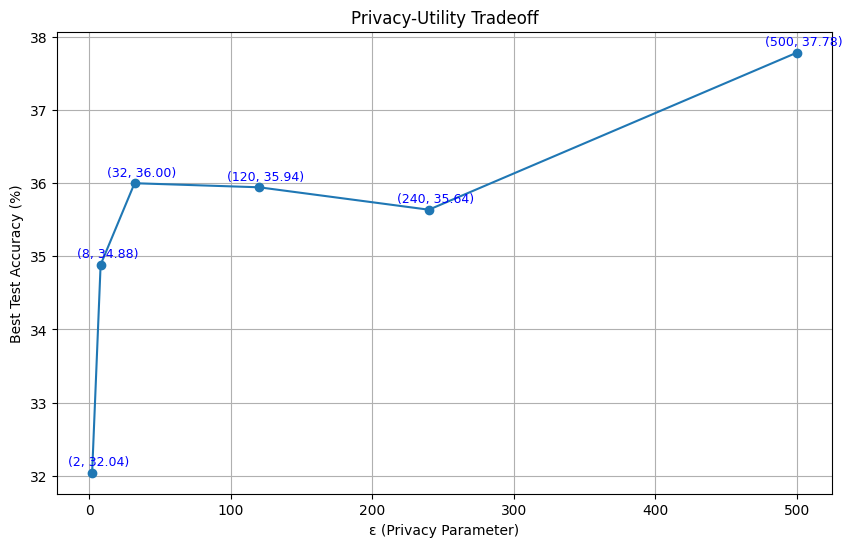

In [76]:
import matplotlib.pyplot as plt

# Prepare data for plotting
epsilon_values = []
best_accuracies = []

for epsilon in epsilons:
    if epsilon in ep_vs_lr:
        epsilon_values.append(epsilon)
        best_accuracies.append(ep_vs_lr[epsilon]['best_accuracy'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, best_accuracies, marker='o')
plt.title('Privacy-Utility Tradeoff')
plt.xlabel('ε (Privacy Parameter)')
plt.ylabel('Best Test Accuracy (%)')
plt.grid(True)

# Adding markings for each point
for i, (epsilon, accuracy) in enumerate(zip(epsilon_values, best_accuracies)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})',  # format with 2 decimal places
                 (epsilon, accuracy),             # point to annotate
                 textcoords="offset points",      # offset the text to avoid overlap
                 xytext=(5, 5),                   # horizontal and vertical offset
                 ha='center',                     # horizontal alignment
                 fontsize=9,                      # text size
                 color="blue")                    # text color

plt.show()


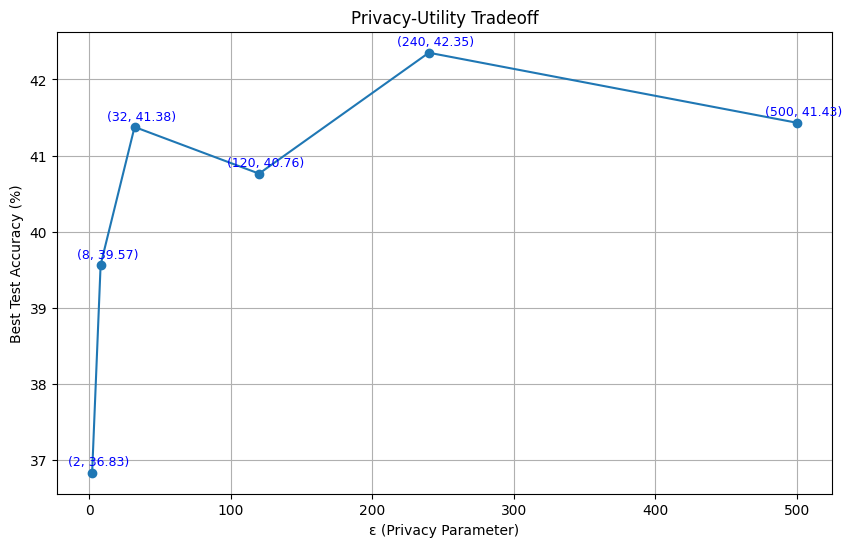

In [116]:
import matplotlib.pyplot as plt

# Prepare data for plotting
epsilon_values = []
best_accuracies = []

for epsilon in epsilons:
    if epsilon in ep_vs_lr:
        epsilon_values.append(epsilon)
        best_accuracies.append(ep_vs_lr[epsilon]['best_accuracy'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, best_accuracies, marker='o')
plt.title('Privacy-Utility Tradeoff')
plt.xlabel('ε (Privacy Parameter)')
plt.ylabel('Best Test Accuracy (%)')
plt.grid(True)

# Adding markings for each point
for i, (epsilon, accuracy) in enumerate(zip(epsilon_values, best_accuracies)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})',  # format with 2 decimal places
                 (epsilon, accuracy),             # point to annotate
                 textcoords="offset points",      # offset the text to avoid overlap
                 xytext=(5, 5),                   # horizontal and vertical offset
                 ha='center',                     # horizontal alignment
                 fontsize=9,                      # text size
                 color="blue")                    # text color

plt.show()


## 1024 batch size

In [13]:
import numpy as np

# List of ε values
epsilons = [2, 8, 32, 120, 240, 500]
ep_vs_lr = {}

n = len(train_dataset)  # Dataset size
delta = 1e-5
batch_size = 100
sampling_rate = batch_size / n
steps = 2400  # Total number of iterations



In [ ]:
from torchvision.models import ResNet18_Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epsilon in epsilons:
    # Calculate the noise multiplier σ
    sigma = get_noise_multiplier(epsilon, delta, sampling_rate, steps)
    if sigma is None:
        continue  # Skip if no σ found
    print(f"Calculated noise multiplier (σ): {sigma} for ε: {epsilon}")

    # Initialize best accuracy for this ε
    best_accuracy = 0
    accuracies = {}

    # Try different learning rates
    learning_rates = [0.1]

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")

        # Reinitialize the model for each learning rate
        # Load pre-trained ResNet-18 model
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to accept single-channel images
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the final fully connected layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Replace BatchNorm layers with GroupNorm
        replace_batchnorm_with_groupnorm(model, num_groups=32)

        model = model.to(device)

        # Initialize model parameters and buffers
        params = {k: v.detach() for k, v in model.named_parameters()}
        buffers = {k: v.detach() for k, v in model.named_buffers()}

        # Move parameters and buffers to the device
        for k in params:
            params[k] = params[k].to(device)
        for k in buffers:
            buffers[k] = buffers[k].to(device)

        # Training loop
        total_batches = 0
        for epoch in range(43):  # Number of epochs
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)

                # Perform DP-SGD update
                params = dp_sgd_update(params, buffers, data, target, C=1.0, sigma=sigma, lr=lr)

                total_batches += 1
                if total_batches >= steps:
                    break  # Stop if we've reached the total number of training steps

            if total_batches >= steps:
                break  # Break outer loop as well

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = functional_call(model, (params, buffers), data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        accuracies[lr] = accuracy
        print(f"Test Accuracy with learning rate {lr}: {accuracy:.2f}%")

    # Store the best accuracy for this ε
    best_lr = max(accuracies, key=accuracies.get)
    best_accuracy = accuracies[best_lr]
    ep_vs_lr[epsilon] = {'best_lr': best_lr, 'best_accuracy': best_accuracy}
    print(f"Best Test Accuracy for ε={epsilon}: {best_accuracy:.2f}% at learning rate {best_lr}")


Calculated noise multiplier (σ): 0.8179822661657955 for ε: 2
Training with learning rate: 0.1


KeyboardInterrupt: 

: 

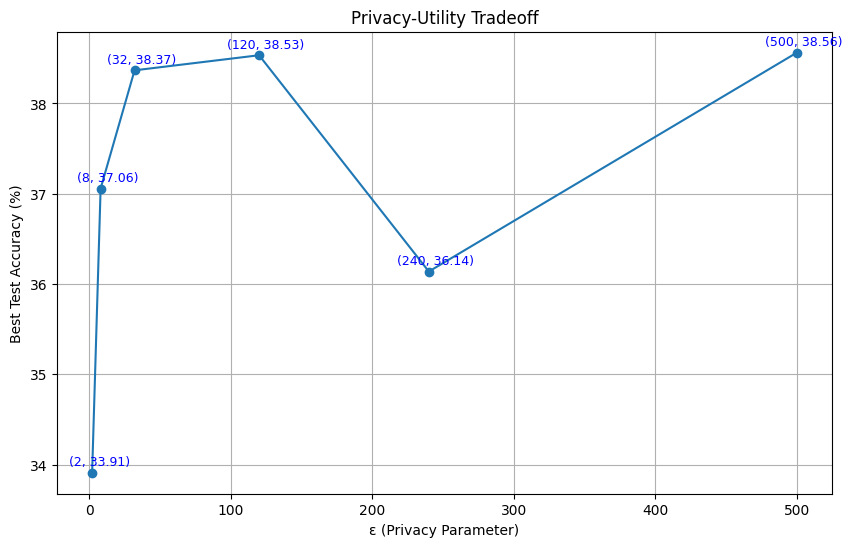

In [79]:
import matplotlib.pyplot as plt

# Prepare data for plotting
epsilon_values = []
best_accuracies = []

for epsilon in epsilons:
    if epsilon in ep_vs_lr:
        epsilon_values.append(epsilon)
        best_accuracies.append(ep_vs_lr[epsilon]['best_accuracy'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, best_accuracies, marker='o')
plt.title('Privacy-Utility Tradeoff')
plt.xlabel('ε (Privacy Parameter)')
plt.ylabel('Best Test Accuracy (%)')
plt.grid(True)

# Adding markings for each point
for i, (epsilon, accuracy) in enumerate(zip(epsilon_values, best_accuracies)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})',  # format with 2 decimal places
                 (epsilon, accuracy),             # point to annotate
                 textcoords="offset points",      # offset the text to avoid overlap
                 xytext=(5, 5),                   # horizontal and vertical offset
                 ha='center',                     # horizontal alignment
                 fontsize=9,                      # text size
                 color="blue")                    # text color

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
epsilon_values = []
best_accuracies = []

for epsilon in epsilons:
    if epsilon in ep_vs_lr:
        epsilon_values.append(epsilon)
        best_accuracies.append(ep_vs_lr[epsilon]['best_accuracy'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, best_accuracies, marker='o')
plt.title('Privacy-Utility Tradeoff')
plt.xlabel('ε (Privacy Parameter)')
plt.ylabel('Best Test Accuracy (%)')
plt.grid(True)

# Adding markings for each point
for i, (epsilon, accuracy) in enumerate(zip(epsilon_values, best_accuracies)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})',  # format with 2 decimal places
                 (epsilon, accuracy),             # point to annotate
                 textcoords="offset points",      # offset the text to avoid overlap
                 xytext=(5, 5),                   # horizontal and vertical offset
                 ha='center',                     # horizontal alignment
                 fontsize=9,                      # text size
                 color="blue")                    # text color

plt.show()
